### Grouping information sources into categories

Question 145 listed 14 information sources, and correspondents could check whichever they considered their most valuable sources.

We decided to group the information sources into the same 6 categories as question 129. This notebook processes the data from Question 145, makes a plot of results, and outputs a spreadsheet with the categorised responses for each subject.

In [11]:
import pandas as pd
import json
import elasticsearch
from matplotlib import pyplot as plt
import collections
import numpy as np
%matplotlib inline

# Import the data. This notebook uses csv files that Gianfranco processed.
# In the processed files, the responses to Q145 are in the same format as Q129.
dfU = pd.read_csv('processed_data/UgandaClean.mapped.Q145_fixed.csv')
dfK = pd.read_csv('processed_data/KenyaClean.mapped.Q145_fixed.csv')

countryData = {
    "Kenya": dfK,
    "Uganda": dfU
}

SUBJECT_COLUMN = "SbjNum"
RESPONSE_COLUMN_PREFIX = "Q145.MostValuableSources.O"

In [12]:
categoryNames = collections.OrderedDict([
    ("experiments", "Own experimentation"),
    ("sharing", "Informal sharing"),
    ("training", "Face-to-face training"),
    ("print", "Print media"),
    ("broadcast", "Broadcast media"),
    ("digital", "Digital media")
])

codeMapping = {
    1: "experiments",
    2: "sharing",
    3: "training",
    4: "training",
    5: "broadcast",
    6: "digital",
    7: "digital",
    8: "print",
    9: "broadcast",
    10: "digital",
    11: "training",
    12: "sharing",
    13: "training",
    14: "print"
}

categoryCodes = collections.defaultdict(list)
for code,category in codeMapping.items():
    categoryCodes[category] += [code]
categoryCodes

defaultdict(list,
            {'broadcast': [5, 9],
             'digital': [6, 7, 10],
             'experiments': [1],
             'print': [8, 14],
             'sharing': [2, 12],
             'training': [3, 4, 11, 13]})

In [13]:
def getColumn(df, code, prefix = RESPONSE_COLUMN_PREFIX):
    return df[prefix + str(code)].values

def categoryColumn(category, country):
    df = countryData[country]
    codes = categoryCodes[category]
    matched_any = np.zeros_like(getColumn(df,1))
    for code in codes:
        matched_any = np.logical_or(matched_any, getColumn(df,code)==1)
    return map(int, matched_any)

def proportionHavingCategory(category, country):
    return np.mean(categoryColumn(category, country))

results = []
for category in categoryNames:
    results.append(dict(
        category = categoryNames[category],
        Kenya = proportionHavingCategory(category,"Kenya"),
        Uganda = proportionHavingCategory(category,"Uganda")
    ))

res_df = pd.DataFrame(results)
res_df = res_df.set_index("category")
res_df

,Kenya,Uganda
category,,
Own experimentation,0.312195,0.472131
Informal sharing,0.380488,0.504918
Face-to-face training,0.604878,0.691803
Print media,0.165854,0.078689
Broadcast media,0.604878,0.383607
Digital media,0.136585,0.052459


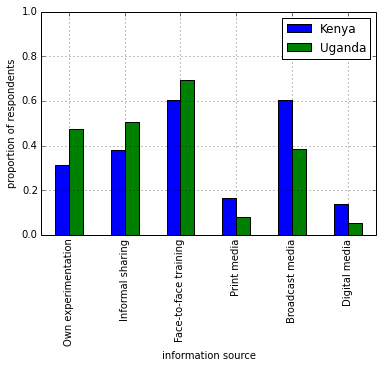

In [14]:
res_df.plot(kind="bar", grid="on")
plt.ylim(0,1)
plt.ylabel("proportion of respondents")
plt.xlabel("information source");

In [15]:
def summarizeInfoSource(digital, inPerson):
    summary = []
    for d,p in zip(digital, inPerson):
        if d and p:
            summary.append("both")
        elif d:
            summary.append("digital")
        elif p:
            summary.append("in-person")
        else:
            summary.append("neither")
    return summary
    
outData = []
for country,df in countryData.items():
    countryOutData = {
        SUBJECT_COLUMN: df[SUBJECT_COLUMN].values,
    }
    for category in categoryNames:
        countryOutData[category] = categoryColumn(category, country)
    countryOutData["country"] = country
    countryOutData["summary"] = summarizeInfoSource(countryOutData["digital"], countryOutData["training"])
    countryOutData["satisfaction"] = df["Q128.SatisfactionSupportInformation"].values
    outData.append(pd.DataFrame(
            countryOutData,
            index=df[SUBJECT_COLUMN].values,
            columns=["SbjNum","country"] + list(categoryNames.keys()) + ["summary","satisfaction"]))
outData = pd.concat(outData)
outData.to_csv("processed_data/Q145InformationSatisfaction.csv", index=False)